# Controlled oscillator

The controlled oscillator is an oscillator
with an extra input that controls the frequency of the oscillation.

To implement a basic oscillator,
we would use a neural ensemble of two dimensions
that has the following dynamics:

$$
\dot{x} = \begin{bmatrix} 0 && - \omega \\ \omega && 0 \end{bmatrix} x
$$

where the frequency of oscillation is $\omega \over {2 \pi}$ Hz.

We need the neurons to represent three variables,
$x_0$, $x_1$, and $\omega$.
According the the dynamics principle of the NEF,
in order to implement some particular dynamics,
we need to convert this dynamics equation into a feedback function:

$$
\begin{align}
  \dot{x} &= f(x) \\
  &\implies f_{feedback}(x) = x + \tau f(x)
\end{align}
$$

where $\tau$ is the post-synaptic time constant of the feedback connection.

In this case, the feedback function to be computed is

$$
\begin{align}
  f_{feedback}(x) &= x + \tau
  \begin{bmatrix}
    0 && - \omega \\
    \omega && 0
  \end{bmatrix}
  x \\
  &=
  \begin{bmatrix}
    x_0 - \tau \cdot \omega \cdot x_1 \\
    x_1 + \tau \cdot \omega \cdot x_0
  \end{bmatrix}
\end{align}
$$

Since the neural ensemble represents all three variables
but the dynamics only affects the first two ($x_0$, $x_1$),
we need the feedback function to not affect that last variable.
We do this by adding a zero to the feedback function.

$$
f_{feedback}(x) = \begin{bmatrix}
  x_0 - \tau \cdot \omega \cdot x_1 \\
  x_1 + \tau \cdot \omega \cdot x_0 \\
 0 \end{bmatrix}
$$

We also generally want to keep
the ranges of variables represented within an ensemble
to be approximately the same.
In this case, if $x_0$ and $x_1$ are between -1 and 1,
$\omega$ will also be between -1 and 1,
giving a frequency range of $-1 \over {2 \pi}$ to $1 \over {2 \pi}$.
To increase this range,
we introduce a scaling factor to $\omega$ called $\omega_{max}$.

$$
f_{feedback}(x) = \begin{bmatrix}
  x_0 - \tau \cdot \omega \cdot \omega_{max} \cdot x_1 \\
  x_1 + \tau \cdot \omega \cdot \omega_{max} \cdot x_0 \\
  0 \end{bmatrix}
$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo
from nengo.processes import Piecewise

## Step 1: Create the network

In [2]:
tau = 0.1  # Post-synaptic time constant for feedback
w_max = 10  # Maximum frequency is w_max/(2*pi)

model = nengo.Network(label='Controlled Oscillator')
with model:
    # The ensemble for the oscillator
    oscillator = nengo.Ensemble(500, dimensions=3, radius=1.7)

    # The feedback connection
    def feedback(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 + w * w_max * tau * x1, x1 - w * w_max * tau * x0, 0

    nengo.Connection(oscillator, oscillator, function=feedback, synapse=tau)

    # The ensemble for controlling the speed of oscillation
    frequency = nengo.Ensemble(100, dimensions=1)

    nengo.Connection(frequency, oscillator[2])

## Step 2: Create the input

In [3]:
with model:
    # We need a quick input at the beginning to start the oscillator
    initial = nengo.Node(Piecewise({0: [1, 0, 0], 0.15: [0, 0, 0]}))
    nengo.Connection(initial, oscillator)

    # Vary the speed over time
    input_frequency = nengo.Node(
        Piecewise({
            0: 1,
            1: 0.5,
            2: 0,
            3: -0.5,
            4: -1
        }))

    nengo.Connection(input_frequency, frequency)

## Step 3: Add Probes

In [4]:
with model:
    # Indicate which values to record
    oscillator_probe = nengo.Probe(oscillator, synapse=0.03)

## Step 4: Run the Model

In [5]:
with nengo.Simulator(model) as sim:
    sim.run(5)

## Step 5: Plot the Results

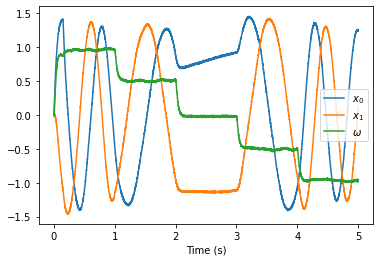

In [6]:
plt.figure()
plt.plot(sim.trange(), sim.data[oscillator_probe])
plt.xlabel('Time (s)')
plt.legend(['$x_0$', '$x_1$', r'$\omega$']);